### Introduction

Not much here except very simple features that build on the fact we know the future...

In all time series competition where you're allowed to use future events the best features are time to next session for a given visitor.

This competition is no exception.

I left part of the features I already tested and don't seem to generalize... but what can we really trust here ?


In [1]:
import os
print(os.listdir("../input"))

['.DS_Store', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

# I don't like SettingWithCopyWarnings ...
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

### Get the extracted data

In [5]:
train = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('../input/create-extracted-json-fields-dataset/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

### Define folding strategy

In [6]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

### Get session target

In [7]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

### Add date features

Only add the one I think can ganeralize

In [8]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source'],
      dtype='object')

In [9]:
train['target'] = y_reg
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60

y_reg = train['target']
del train['target']

In [10]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train = custom(train)
test = custom(test)

process device ...
process device ...
custom..
custom..


### Create features list

In [11]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

### Factorize categoricals

In [12]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

### Predict revenues at session level

In [13]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

In [14]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom', 'next_session_1', 'next_session_2', 'source.country', 'campaign.medium', 'browser.category', 'browser.os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork.city_device.browser', 'geoNetwork.city_device.deviceCategory', 'geoNetwork.city_device.operatingSystem', 'geoNetwork.city_trafficSource.source', 'geoNetwork.continent_device.browser', 'geoNetwork

1.602282315443837

### Display feature importances

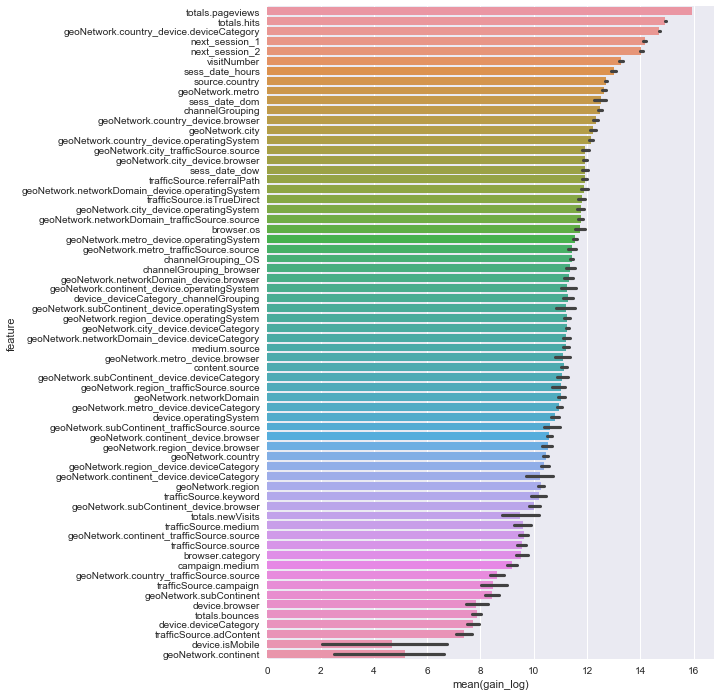

In [15]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

### Create user level predictions

In [16]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [17]:
# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [18]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 45.8 s, sys: 278 ms, total: 46.1 s
Wall time: 46.2 s


In [19]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log1p


(714167, 349)

In [20]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

CPU times: user 39.2 s, sys: 300 ms, total: 39.5 s
Wall time: 39.4 s


In [21]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

/Users/Zion/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log1p


(617242, 349)

### Create target at Visitor level

In [22]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

### Train a model at Visitor level

In [27]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
oof_preds1 = np.zeros(full_data.shape[0])
oof_preds2 = np.zeros(full_data.shape[0])

both_oof = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    print("-"* 20 + "Fold :"+str(fold_) + "-"* 20)
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    print("-"* 20 + "LightGBM Training" + "-"* 20)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    print("-"* 20 + "Xgboost Training" + "-"* 20)
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    cat = CatBoostRegressor(iterations=1000,learning_rate=0.03,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 42,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 50,
                            od_wait=20)
    print("-"* 20 + "Catboost Training" + "-"* 20)
    cat.fit(trn_x, np.log1p(trn_y), eval_set=[(val_x, np.log1p(val_y))],early_stopping_rounds=50,use_best_model=True,verbose=100)
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')

    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)

    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds1[val_] = xg.predict(val_x)
    oof_preds2[val_] = cat.predict(val_x)

    oof_preds[oof_preds < 0] = 0
    oof_preds1[oof_preds1 < 0] = 0
    oof_preds2[oof_preds2 < 0] = 0

    both_oof[val_] = oof_preds[val_] * 0.35 + oof_preds1[val_] * 0.3 + oof_preds2[val_] * 0.35

    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0

    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0

    pre_ = cat.predict(sub_full_data[full_data.columns])
    pre_[pre_<0]=0

    sub_preds += (_preds / len(folds)) * 0.35 + (pre / len(folds)) * 0.3 + (pre_ / len(folds)) * 0.35
    
print("LGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)
print("XGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds1) ** .5)
print("CAT  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds2) ** .5)

print("Combine  ", mean_squared_error(np.log1p(trn_user_target['target']), both_oof) ** .5)

--------------------Fold :0--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53319	VALID's rmse: 1.59142
[200]	TRAIN's rmse: 1.4929	VALID's rmse: 1.58829
Early stopping, best iteration is:
[197]	TRAIN's rmse: 1.49368	VALID's rmse: 1.58827
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11064	validation_1-rmse:2.1107
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.71414	validation_1-rmse:1.74069
[200]	validation_0-rmse:1.59847	validation_1-rmse:1.64516
[300]	validation_0-rmse:1.54059	validation_1-rmse:1.60725
[400]	validation_0-rmse:1.51788	validation_1-rmse:1.59846
[500]	validation_0-rmse:1.49721	validation_1-rmse:1.59372
[600]	validation_0-rmse:1.48016	validation_1-rmse:1.59199
[700]	validation_0-rmse:1.465

0:	learn: 2.0872295	test: 2.0875405	best: 2.0875405 (0)	total: 849ms	remaining: 14m 8s
100:	learn: 1.5368272	test: 1.5896360	best: 1.5896360 (100)	total: 1m 33s	remaining: 13m 51s
200:	learn: 1.4974733	test: 1.5856860	best: 1.5855926 (197)	total: 2m 59s	remaining: 11m 54s
300:	learn: 1.4684064	test: 1.5853941	best: 1.5851831 (285)	total: 4m 35s	remaining: 10m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.585183051
bestIteration = 285

Shrink model to first 286 iterations.
--------------------Fold :1--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53282	VALID's rmse: 1.59401
Early stopping, best iteration is:
[139]	TRAIN's rmse: 1.51329	VALID's rmse: 1.59113
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11069	validation_1-rmse:2.1122
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early

0:	learn: 2.0869757	test: 2.0896911	best: 2.0896911 (0)	total: 789ms	remaining: 13m 8s
100:	learn: 1.5389250	test: 1.5913080	best: 1.5913080 (100)	total: 1m 40s	remaining: 14m 50s
200:	learn: 1.5006610	test: 1.5883283	best: 1.5878689 (181)	total: 3m 13s	remaining: 12m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.587868912
bestIteration = 181

Shrink model to first 182 iterations.
--------------------Fold :2--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53319	VALID's rmse: 1.58489
[200]	TRAIN's rmse: 1.49275	VALID's rmse: 1.5813
Early stopping, best iteration is:
[195]	TRAIN's rmse: 1.49418	VALID's rmse: 1.5812
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11104	validation_1-rmse:2.11467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rm

0:	learn: 2.0864943	test: 2.0903862	best: 2.0903862 (0)	total: 823ms	remaining: 13m 42s
100:	learn: 1.5331812	test: 1.5887110	best: 1.5887110 (100)	total: 1m 18s	remaining: 11m 34s
200:	learn: 1.4958163	test: 1.5857017	best: 1.5852308 (170)	total: 2m 29s	remaining: 9m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.585230769
bestIteration = 170

Shrink model to first 171 iterations.
--------------------Fold :3--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53968	VALID's rmse: 1.56465
[200]	TRAIN's rmse: 1.49937	VALID's rmse: 1.56188
Early stopping, best iteration is:
[200]	TRAIN's rmse: 1.49937	VALID's rmse: 1.56188
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11461	validation_1-rmse:2.10073
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-

0:	learn: 2.0903874	test: 2.0754559	best: 2.0754559 (0)	total: 624ms	remaining: 10m 23s
100:	learn: 1.5406967	test: 1.5690090	best: 1.5690090 (100)	total: 1m 14s	remaining: 11m 3s
200:	learn: 1.5028462	test: 1.5673402	best: 1.5669383 (186)	total: 2m 28s	remaining: 9m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.566938265
bestIteration = 186

Shrink model to first 187 iterations.
--------------------Fold :4--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53086	VALID's rmse: 1.59511
Early stopping, best iteration is:
[129]	TRAIN's rmse: 1.51535	VALID's rmse: 1.59381
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11007	validation_1-rmse:2.11885
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation

0:	learn: 2.0854389	test: 2.0944163	best: 2.0944163 (0)	total: 615ms	remaining: 10m 14s
100:	learn: 1.5341095	test: 1.5948058	best: 1.5948022 (99)	total: 1m 14s	remaining: 11m 1s
200:	learn: 1.4930274	test: 1.5923928	best: 1.5923928 (200)	total: 2m 27s	remaining: 9m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.592354595
bestIteration = 215

Shrink model to first 216 iterations.
LGB   1.5832989648547977
XGB   1.5853096254858177
CAT   1.5835349411153847
Combine   1.5802343315906617


In [23]:
from xgboost import XGBRegressor
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
oof_preds1 = np.zeros(full_data.shape[0])
both_oof = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    print("-"* 20 + "Fold :"+str(fold_) + "-"* 20)
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    print("-"* 20 + "LightGBM Training" + "-"* 20)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    print("-"* 20 + "Xgboost Training" + "-"* 20)
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')

    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)

    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds1[val_] = xg.predict(val_x)

    oof_preds[oof_preds < 0] = 0
    oof_preds1[oof_preds1 < 0] = 0

    both_oof[val_] = oof_preds[val_] * 0.6 + oof_preds1[val_] * 0.4

    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0

    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0

    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
print("LGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5)
print("XGB  ", mean_squared_error(np.log1p(trn_user_target['target']), oof_preds1) ** .5)
print("Combine  ", mean_squared_error(np.log1p(trn_user_target['target']), both_oof) ** .5)

--------------------Fold :0--------------------
--------------------LightGBM Training--------------------
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.53319	VALID's rmse: 1.59142
[200]	TRAIN's rmse: 1.4929	VALID's rmse: 1.58829
Early stopping, best iteration is:
[197]	TRAIN's rmse: 1.49368	VALID's rmse: 1.58827
--------------------Xgboost Training--------------------
[0]	validation_0-rmse:2.11064	validation_1-rmse:2.1107
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.71414	validation_1-rmse:1.74069
[200]	validation_0-rmse:1.59847	validation_1-rmse:1.64516
[300]	validation_0-rmse:1.54059	validation_1-rmse:1.60725
[400]	validation_0-rmse:1.51788	validation_1-rmse:1.59846
[500]	validation_0-rmse:1.49721	validation_1-rmse:1.59372
[600]	validation_0-rmse:1.48016	validation_1-rmse:1.59199
[700]	validation_0-rmse:1.465

### Display feature importances

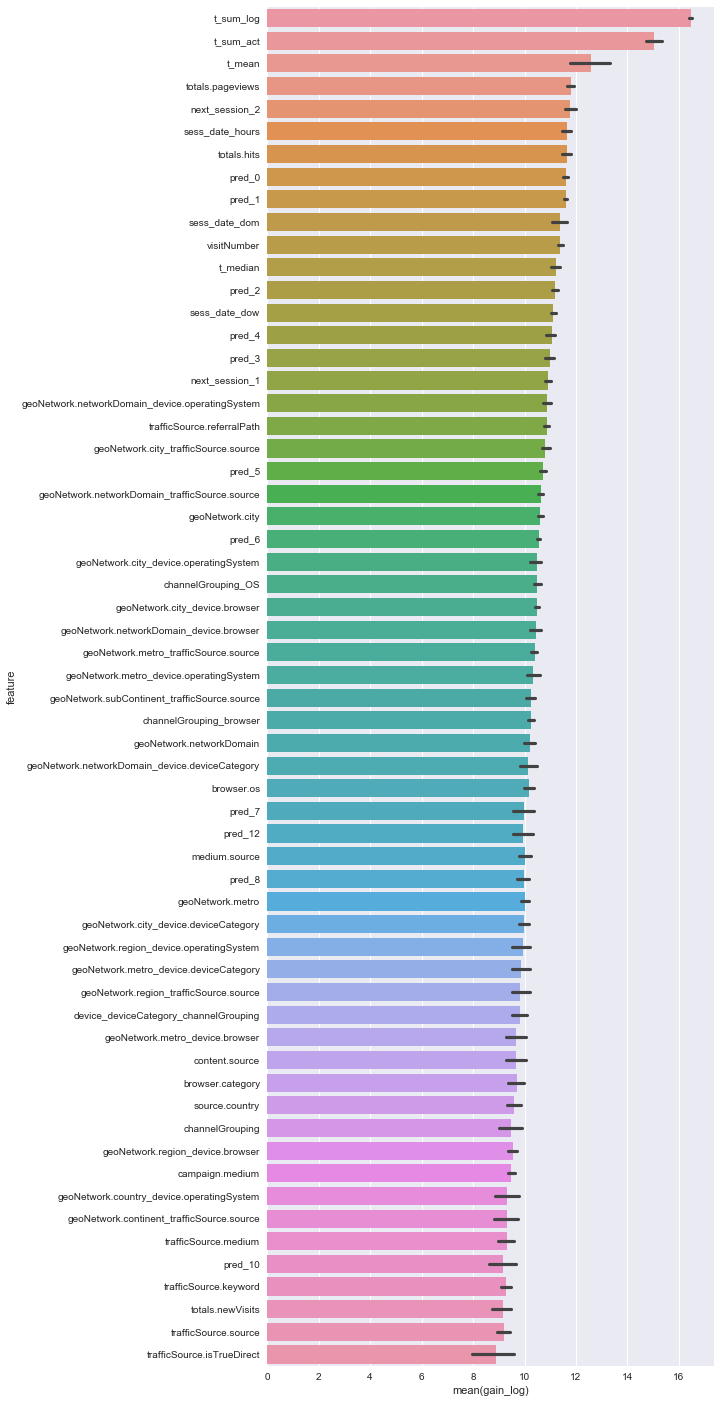

In [28]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [30]:
tips = 2

### Save predictions

In [31]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('new_test_3_models.csv', index=True)